# Exploration du dataset FairFace

Comprendre la structure du dataset FairFace, fusionner les labels officiels et visualiser des exemples.

**Objectifs**
- Charger les fichiers de labels officiels (`fairface_label_train.csv`, `fairface_label_val.csv`) et les images rangées dans `../data/raw/fairface/train/` et `../data/raw/fairface/val/`.
- Fusionner labels + chemins d'images dans un DataFrame `pandas`.
- Visualiser des exemples aléatoires et par groupe (`race`, `gender`, `age`).
- Tracer des distributions et vérifier la structure du dataset.

In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
from PIL import Image # bibliotheque pillow, permet de charger, afficher et traiter des images
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
DATA_DIR = Path('../data/raw/fairface')  
TRAIN_DIR = DATA_DIR / 'train'
VAL_DIR   = DATA_DIR / 'val'
TRAIN_CSV = DATA_DIR / 'fairface_label_train.csv'
VAL_CSV   = DATA_DIR / 'fairface_label_val.csv'

print('DATA_DIR exists:', DATA_DIR.exists())
print('TRAIN_DIR exists:', TRAIN_DIR.exists(), ' - #files:', len(list(TRAIN_DIR.rglob('*.jpg'))) if TRAIN_DIR.exists() else 0)
print('VAL_DIR exists:', VAL_DIR.exists(), ' - #files:', len(list(VAL_DIR.rglob('*.jpg'))) if VAL_DIR.exists() else 0)
print('TRAIN_CSV exists:', TRAIN_CSV.exists())
print('VAL_CSV exists:', VAL_CSV.exists())

DATA_DIR exists: True
TRAIN_DIR exists: True  - #files: 86744
VAL_DIR exists: True  - #files: 10954
TRAIN_CSV exists: True
VAL_CSV exists: True


In [18]:
train_df = pd.read_csv(TRAIN_CSV)
val_df   = pd.read_csv(VAL_CSV)

train_df['split'] = 'train'
val_df['split']   = 'val'

df = pd.concat([train_df, val_df], ignore_index=True)
print('Total images in labels (train+val):', len(df))
df.head()

Total images in labels (train+val): 97698


,file,age,gender,race,service_test,split
0,train/1.jpg,50-59,Male,East Asian,True,train
1,train/2.jpg,30-39,Female,Indian,False,train
2,train/3.jpg,3-9,Female,Black,False,train
3,train/4.jpg,20-29,Female,Indian,True,train
4,train/5.jpg,20-29,Female,Indian,True,train


In [ ]:
# Construire le chemin complet vers les images et vérifier l'existence des fichiers
def get_img_path(row):
    return DATA_DIR / row['file']

df['img_path'] = df.apply(get_img_path, axis = 1)

# vérifier existence des fichiers et afficher quelques exemples manquants
exists_mask = df['img_path'].apply(lambda p: p.exists())
missing = df[~exists_mask]
print('Images référencées manquantes:', len(missing))
if len(missing) > 0:
    display(missing.head())

# Garder seulement les lignes dont l'image est disponible
df = df[exists_mask].reset_index(drop=True)
print('Images disponibles après filtrage:', len(df))
df.sample(5)

Images référencées manquantes: 0
Images disponibles après filtrage: 97698


,file,age,gender,race,service_test,split,img_path
27122,train/27123.jpg,50-59,Female,East Asian,True,train,..\data\raw\fairface\train\27123.jpg
81867,train/81868.jpg,30-39,Male,Latino_Hispanic,True,train,..\data\raw\fairface\train\81868.jpg
30471,train/30472.jpg,30-39,Female,Latino_Hispanic,False,train,..\data\raw\fairface\train\30472.jpg
84294,train/84295.jpg,60-69,Male,Middle Eastern,False,train,..\data\raw\fairface\train\84295.jpg
12949,train/12950.jpg,10-19,Female,Indian,False,train,..\data\raw\fairface\train\12950.jpg


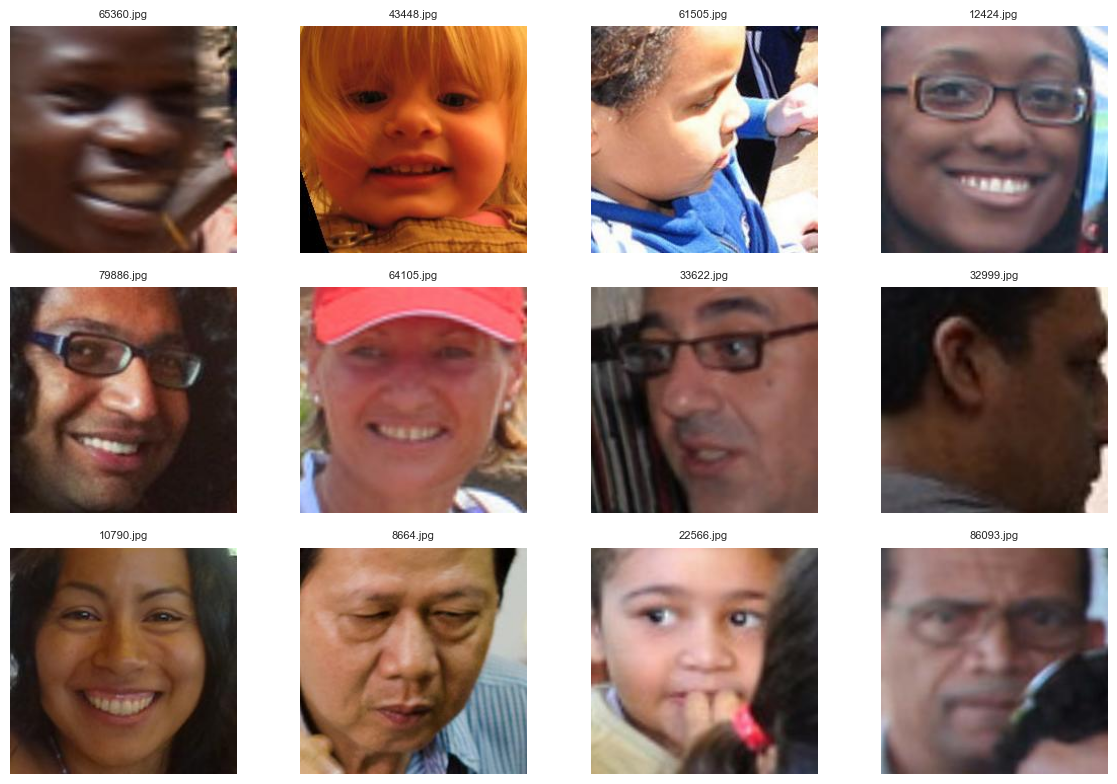

In [20]:
# afficher une grille d'images
def show_images(paths, titles=None, ncols=4, figsize=(12,8)):
    n = len(paths)
    ncols = min(ncols, n)
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()
    for i, p in enumerate(paths):
        try:
            img = Image.open(p).convert('RGB')
            axes[i].imshow(img)
            if titles is not None:
                axes[i].set_title(str(titles[i]), fontsize=8)
            else:
                axes[i].set_title(p.name, fontsize=8)
            axes[i].axis('off')
        except Exception as e:
            axes[i].text(0.5,0.5,f'err:\n{e}', ha='center')
            axes[i].axis('off')
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()

# Afficher 12 images aléatoires du dataset
sample_paths = df['img_path'].sample(12, random_state=42).tolist()
show_images(sample_paths, ncols=4)

Groups (race): ['East Asian', 'Indian', 'Black', 'White', 'Middle Eastern', 'Latino_Hispanic', 'Southeast Asian']
Race: East Asian — 13837 images, showing 6


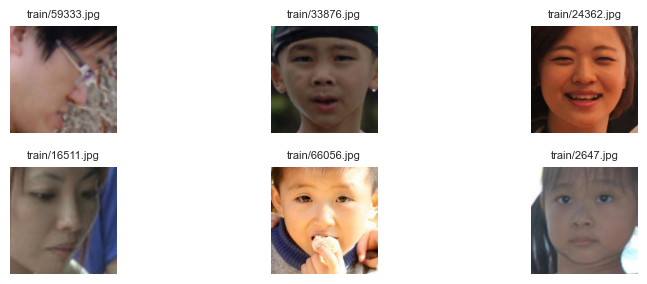

Race: Indian — 13835 images, showing 6


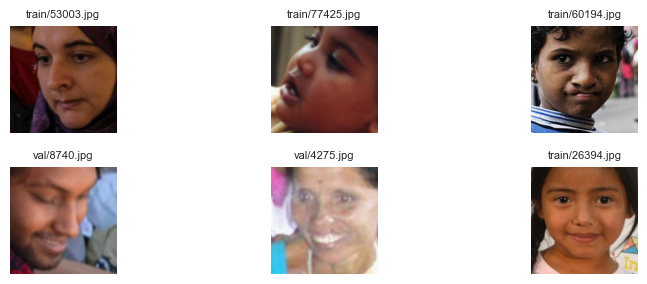

Race: Black — 13789 images, showing 6


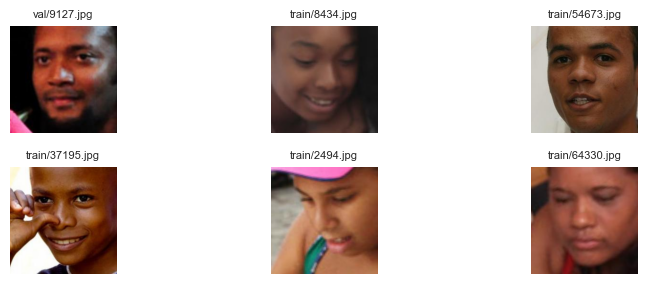

Race: White — 18612 images, showing 6


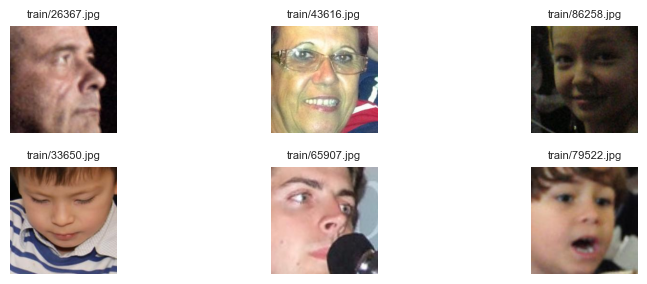

Race: Middle Eastern — 10425 images, showing 6


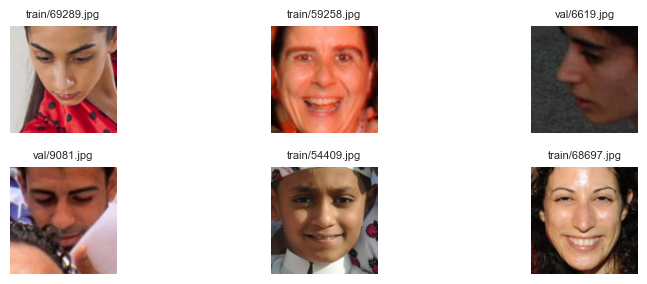

Race: Latino_Hispanic — 14990 images, showing 6


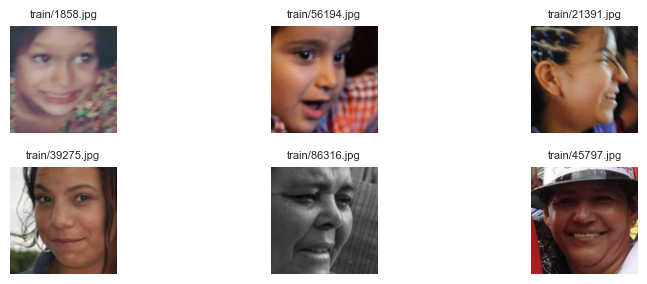

Race: Southeast Asian — 12210 images, showing 6


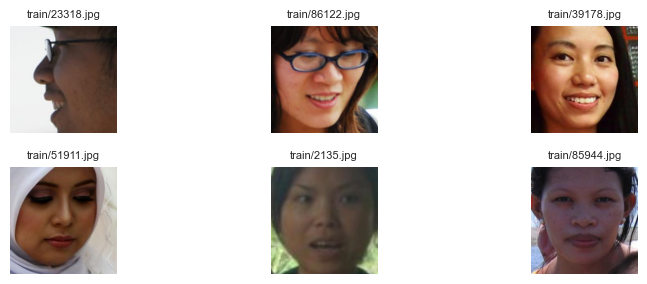

In [ ]:
# Afficher des exemples par 'race'
groups = df['race'].unique().tolist()
print('Groups (race):', groups)

# pour chaque groupe, afficher jusqu'à 6 images
for g in groups:
    subset = df[df['race'] == g]
    n = min(6, len(subset))
    if n == 0:
        continue
    print(f"Race: {g} - {len(subset)} images, showing {n}")
    paths = subset.sample(n, random_state=1)['img_path'].tolist()
    titles = subset.sample(n, random_state=1)['file'].tolist()
    show_images(paths, titles=titles, ncols=3, figsize=(9, 3))

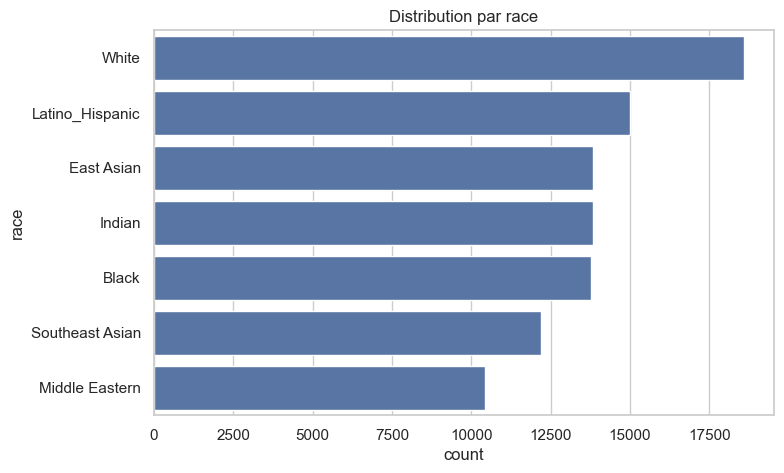

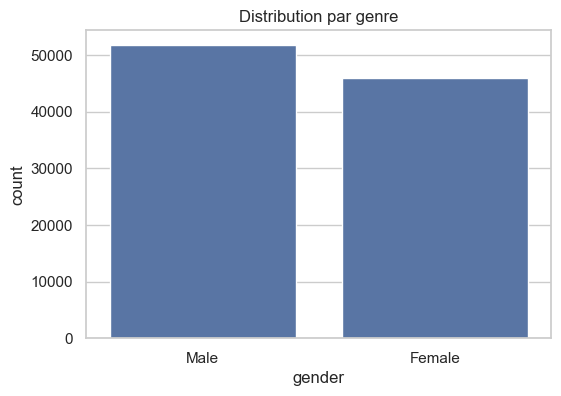

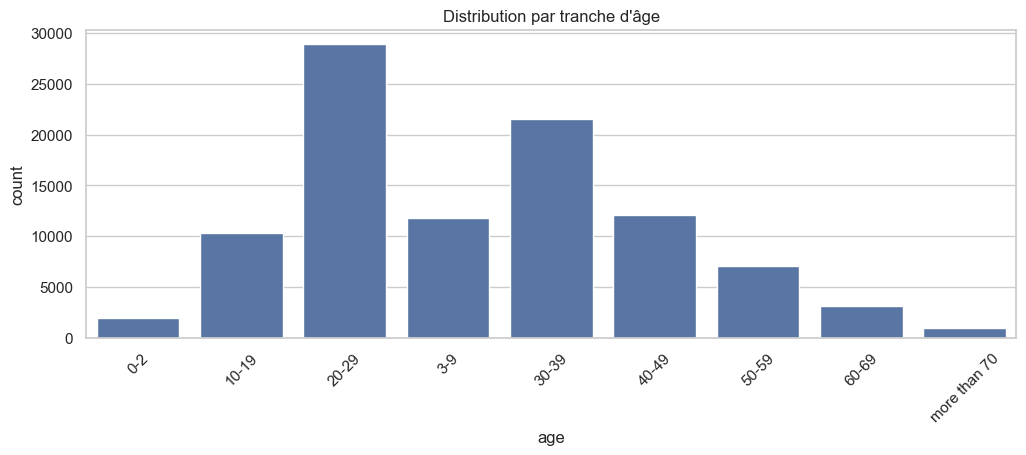

In [ ]:
# Tracer les distributions : race, gender, age

plt.figure(figsize=(8,5))
sns.countplot(y='race', data=df, order=df['race'].value_counts().index)
plt.title('Distribution par race')
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x='gender', data=df)
plt.title('Distribution par genre')
plt.show()

plt.figure(figsize=(12,4))
# si la colonne age contient ranges comme '20-29', triez par ordre naturel si possible
age_order = sorted(df['age'].unique(), key=lambda x: str(x))
sns.countplot(x='age', data=df, order=age_order)
plt.xticks(rotation=45)
plt.title('Distribution par tranche d\'âge')
plt.show()

In [23]:
# Statistiques rapides & sauvegarde d'un sous-échantillon
print('Total images:', len(df))
print('Counts per race:')
print(df['race'].value_counts())
print('\nCounts per gender:')
print(df['gender'].value_counts())

# Sauvegarder un petit échantillon équilibré (optionnel)
out_sample = DATA_DIR / 'fairface_sample_balanced.csv'
# exemple : prendre 200 images par race si possible
sampled = df.groupby('race').apply(lambda x: x.sample(min(len(x), 200), random_state=42)).reset_index(drop=True)
sampled.to_csv(out_sample, index=False)
print('Saved balanced sample to', out_sample)

Total images: 97698
Counts per race:
race
White              18612
Latino_Hispanic    14990
East Asian         13837
Indian             13835
Black              13789
Southeast Asian    12210
Middle Eastern     10425
Name: count, dtype: int64

Counts per gender:
gender
Male      51778
Female    45920
Name: count, dtype: int64
Saved balanced sample to ..\data\raw\fairface\fairface_sample_balanced.csv


C:\Users\ulric\AppData\Local\Temp\ipykernel_26124\1867070205.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled = df.groupby('race').apply(lambda x: x.sample(min(len(x), 200), random_state=42)).reset_index(drop=True)


In [24]:
df.to_csv(DATA_DIR/"fairface.csv", index = False)